In [27]:
import os
from pathlib import Path, PurePath
import math
from fastai.vision.all import *
from nnAudio import features
import torchaudio
from torchvision import transforms as T
from timesformer_pytorch import TimeSformer
from cv2 import cv2

# Polar representation of CQT Spectrograms
Constant Q transforms (CQT) uses longer frames on lower frequencies and shorter on higher (As far as i understand it).  
This means that we have a dynamic spectral/time resolution, and therefore do not loose as much information as with normal STFTs. 

## Hypothesis
Lower frequencies changes less often than higher.  
That means that the amount of inforation grows with frequency.  
If higher frequencies get more space (pixels) and and lower frequencies gets less,  
one can assume the information density in each spectrogram is optimal.
   
One way to to achieve this is wraping the rectangular images to a circle,  
such that lower friequencies will be in the middle of that circle, and higher on the edges.  
This gives higher frequencies more space as the circumference of a circle grows with its radius.
  

### Gather data

In [28]:
path = Path('../dataset/DeepShip')
sr = 32000

In [29]:
fns =  get_files(path,'.wav')

In [30]:
fns

(#621) [Path('../dataset/DeepShip/Tug/20171202-37/071515.wav'),Path('../dataset/DeepShip/Tug/20171106a-5/162112.wav'),Path('../dataset/DeepShip/Tug/20171217a-59/050224.wav'),Path('../dataset/DeepShip/Tug/20171118c-15/185844.wav'),Path('../dataset/DeepShip/Tug/20171219a-60/210546.wav'),Path('../dataset/DeepShip/Tug/20171202a-38/145149.wav'),Path('../dataset/DeepShip/Tug/20171229b-68/200347.wav'),Path('../dataset/DeepShip/Tug/20171124-22/012051.wav'),Path('../dataset/DeepShip/Tug/20171223b-63/233721.wav'),Path('../dataset/DeepShip/Tug/20171118b-14/161506.wav')...]

In [31]:
# Figure out fft sizes


### Reading wav, making and normalizing spectrograms

In [32]:
def normSamp(audio):
    ret = audio - torch.mean(audio)
    return ret / torch.max(ret)

def normSpec(spec):
    # take the logarithm of the values
    ret = torch.log10(spec+1e-20)
    mean = torch.mean(ret)
    std = torch.std(ret)
    # Normalize each frame so its max 1, we dont need the extra dimension
    #return (ret / torch.transpose(torch.max(ret,2)[0],0,1))[0]
    #return (ret / torch.max(ret))[0]
    
    ret =  (ret - mean) / (std*4) + 0.5
    return torch.clamp(ret, min=0, max=1) 

def normCqt(cqt):
    ret = torch.log10(cqt) / 2
    #return (ret / torch.max(ret,1)[0])[0]
    ret = (ret - torch.mean(ret) + 0.5)
    return torch.clamp(ret, min=0, max=1) 


In [33]:
def readWav(p: Path, num_frames = -1, rand=True):
    frames = torchaudio.info(p).num_frames
    last_start = frames-num_frames if num_frames >0  else frames

    # If enough frames, return selection
    if last_start > 0: 
        # Random start point or middle of file
        start = random.randint(0,last_start) if rand else int(last_start/2)
        return torchaudio.load(p, num_frames=num_frames, frame_offset=start)[0]
    # if not enough frames in audioclip, return everything
    else: 
        return torchaudio.load(p)[0]


### The spectogram transforms

In [34]:
#  CQT
img_size = 224

hop_lf = sr//4
rng_lf = hop_lf * ( img_size - 1 )
cqt_lf = features.CQT(sr=sr,hop_length=hop_lf, bins_per_octave=51, fmin=8, fmax=3500, verbose=False).cuda()

nfft_hf = 512
hop_hf = int(nfft_hf*0.9)
rng_hf = hop_hf * ( img_size - 1 ) #+ nfft_hf
stft_hf = features.STFT(sr=sr,n_fft=nfft_hf,hop_length=hop_hf,output_format='Magnitude',verbose=False).cuda()

In [35]:
#features.STFT?

In [36]:
class Spectrogram(TensorImageBase):
    """Type to represent a spectogram which knows show itself"""
    @classmethod
    def create(cls, o: Tensor):
        return cls(o)
    
    def show(self, figsize=None, ctx=None, **kwargs): 
        channels = self.shape[0]
        t = self
        if not isinstance(t, Tensor): return ctx 
        if figsize is None: figsize=(10,10)   
        #f, axarr = plt.subplots(1,3,figsize=(15,15))
        #axarr[0].imshow(specs[0,:,:].cpu(),extent=[0,imgsize,(imgsize+1)*Fbin_lf,Fbin_lf] ,aspect=1/Fbin_lf)
        #axarr[1].imshow(specs[1,:,:].cpu(),extent=[0,imgsize,(imgsize+50)*Fbin_hf,Fbin_hf*50] ,aspect=1/Fbin_hf)
        #axarr[2].imshow(specs[2,:,:].cpu())
        return show_images(t, nrows=1, ncols=channels)

In [55]:
def wavToSpecs(wavs : torch.Tensor, hf_idx=0, pad_random=True):
    img = cqt_lf(wavs[0,:rng_lf])[0]
    
    img_len = img.shape[1]
    if img_len < img_size:
        pad = img_size-img_len
        
        # Reflect Padding
        if pad > img_len: 
            pad_left = random.randint(0,img_len-1) if pad_random else img_len -1
            pad_right = random.randint(0,img_len-1) if pad_random else img_len -1
        else:     
            pad_left = random.randint(0,pad) if pad_random else pad//2
            pad_right = pad - pad_left;
            
        img = torch.nn.functional.pad(img,(pad_left,pad_right),'reflect')
        img = img[:,0:img_size]
        .
        # Repeat padding
        img_len = img.shape[1]
        if (img_len < img_size):
            repeat = math.ceil(img_size / img_len)
            for i in range(repeat):
                if i%2==0:
                    img = torch.cat((img,torch.fliplr(img)),1)
                else:
                    img = torch.cat((img,img),1)    
            #img = img.repeat(1,repeat)
            start = random.randint(0,img_len*repeat-img_size) if pad_random else 0
            img = img[:,start:start+img_size]
            
    lf = normCqt(img[0:img_size])
    mf = normCqt(img[img_size:img_size*2])
    .
    img = stft_hf(wavs[0,hf_idx:hf_idx+rng_hf])[0]
    hf = normSpec(img[13:-20])
    return Spectrogram.create(torch.stack((lf, mf, hf),0))

### Testing transforms

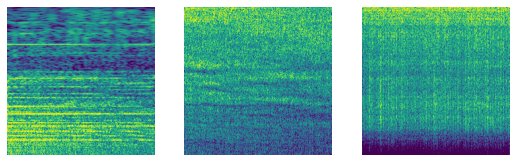

In [56]:
file = fns[33]
wav = readWav(file, rng_lf, True).cuda()
img = wavToSpecs(wav,0, True)
img.show()

# The transform

In [57]:
#norm = T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

In [58]:
def label_func(p : Path):
    if PurePath(p).parent.name == "AmbientSE": return []
    return [PurePath(p).parent.parent.name]

In [59]:
label_func(fns[245])

['Tanker']

In [60]:
#show_image??

In [61]:
# Make a fastai Transform
class SpectrogramTransform(RandTransform):
    "A transform handler for multiple `spect` transforms"
    split_idx,order=None,0  # 0 = HIGH prio
    #def __init__(self, train_aug, valid_aug): store_attr()
    def __init__(self): 
        store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, p : Path):
        
        if self.idx == 0: #Train transform
            wav = readWav(p, rng_lf, True)
            hf_idx = random.randint(0,wav.shape[1]-rng_hf)
            return wavToSpecs(wav.cuda(), hf_idx, True)
        else: #Valid transform
            wav = readWav(p, rng_lf, False)
            hf_idx = (wav.shape[1]-rng_hf) //2
            return wavToSpecs(wav.cuda(), hf_idx, False)
    
    #def decodes(self, x): return TitledImage(x,'test')
def get_wavs(p : Path) :
    l = get_files(p,'.wav')
    ret = L()
    for f in l:
        frames = torchaudio.info(f).num_frames
        if frames*2 > rng_lf:
            ret.append(f)
    return ret
#class ImgTransform(ItemTransform):
#    def __init__(self, vocab): self.vocab = vocab
#    def encodes(self, o): return o
    #def decodes(self, x): return TitledImage(x[0],self.vocab[x[1]])

In [62]:
class PolarTransform(ItemTransform):
    split_idx = None
    
    def encodes(self, tensor : torch.Tensor):
        # Rearrange and move to cpu
        transposed = torch.transpose(img*255,1,2).permute(1,2,0).cpu().numpy()
        height, width = transposed.shape[:2]
        center = (height/2, width/2)
        radius = np.sqrt(((height/2.0)**2.0)+((width/2.0)**2.0))
        polar_image = cv2.linearPolar(transposed, center, radius, cv2.WARP_FILL_OUTLIERS+cv2.WARP_INVERSE_MAP)
        return torch.from_numpy(np.swapaxes(polar_image,0, 2))
    
    

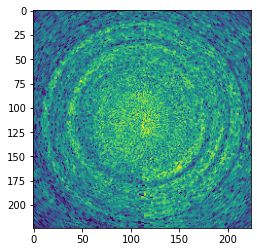

In [63]:
p = PolarTransform
test  = p.encodes(img)
plt.imshow(test[1])

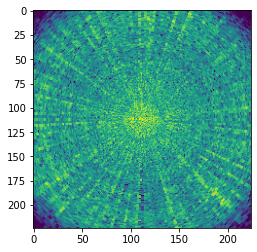

In [64]:
plt.imshow(test[2])

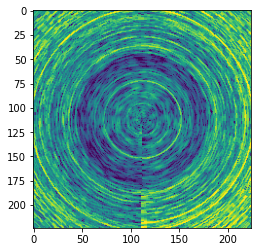

In [65]:
plt.imshow(test[0])

# Training

In [66]:
db = DataBlock(blocks=(TransformBlock(type_tfms=SpectrogramTransform),  MultiCategoryBlock),
               get_items = get_wavs,
               get_y = label_func,
               splitter = RandomSplitter(valid_pct=0.2, seed=42),
               item_tfms=PolarTransform
             )

In [68]:
dls = db.dataloaders(path, bs=16, num_workers=0)

In [69]:
dls.vocab

['Cargo', 'Passengership', 'Tanker', 'Tug']

Experimenting with different optimization functions

In [70]:
learn = cnn_learner(dls, resnet50,  n_in=3, pretrained=True,
                    loss_func=BCEWithLogitsLossFlat(),
                    opt_func = ranger,  # partial(OptimWrapper, opt=torch.optim.SGD)
                    metrics=[accuracy_multi]).to_fp16() #partial(accuracy_multi, thresh=0.95)

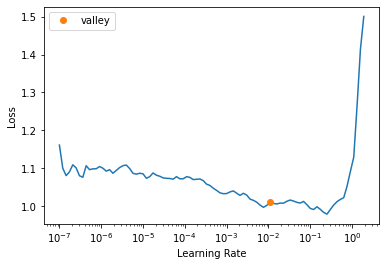

In [71]:
lr = learn.lr_find()

In [29]:
#SaveModelCallback?

In [30]:
cbs = [SaveModelCallback(fname='polar',monitor='accuracy_multi')]
learn.fine_tune(200,base_lr=1e-3, cbs=cbs, MixUp())

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.995101,0.836330,0.459906,01:47


Better model found at epoch 0 with accuracy_multi value: 0.4599056541919708.


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.977980,0.781980,0.544811,01:38
1,0.955079,0.769878,0.542453,01:38
2,0.952854,0.763129,0.556604,01:38
3,0.943779,0.722336,0.589623,01:38
4,0.939416,0.741714,0.603774,01:38
5,0.920795,0.720186,0.613208,01:38
6,0.906511,0.722582,0.601415,01:38
7,0.892363,0.701476,0.622642,01:38
8,0.894648,0.705730,0.617925,01:38
9,0.859029,0.702658,0.629717,01:39


Better model found at epoch 0 with accuracy_multi value: 0.5448113083839417.
Better model found at epoch 2 with accuracy_multi value: 0.5566037893295288.
Better model found at epoch 3 with accuracy_multi value: 0.5896226167678833.
Better model found at epoch 4 with accuracy_multi value: 0.6037735939025879.
Better model found at epoch 5 with accuracy_multi value: 0.6132075190544128.
Better model found at epoch 7 with accuracy_multi value: 0.6226415038108826.
Better model found at epoch 9 with accuracy_multi value: 0.6297169923782349.
Better model found at epoch 10 with accuracy_multi value: 0.6367924809455872.
Better model found at epoch 11 with accuracy_multi value: 0.6415094137191772.
Better model found at epoch 12 with accuracy_multi value: 0.6580188870429993.
Better model found at epoch 15 with accuracy_multi value: 0.6698113083839417.
Better model found at epoch 16 with accuracy_multi value: 0.6910377144813538.
Better model found at epoch 18 with accuracy_multi value: 0.70990568399

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



SuggestedLRs(valley=0.0006918309954926372)

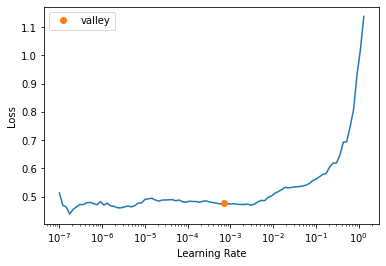

In [63]:
#learn.fit_flat_cos(2, lr=6e-3)
learn.unfreeze()
learn.lr_find()

In [64]:
learn.fit_flat_cos(100, lr=7e-4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.493619,0.414543,0.813679,01:36
1,0.459920,0.424033,0.813679,01:37
2,0.477210,0.396262,0.825472,01:37
3,0.449472,0.348611,0.849057,01:38
4,0.416737,0.355532,0.851415,01:38
5,0.385111,0.323484,0.867925,01:37
6,0.367717,0.319759,0.884434,01:36
7,0.346238,0.718446,0.757075,01:36
8,0.336887,0.280861,0.884434,01:38
9,0.335922,0.343173,0.849057,01:37


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(100,base_lr=7e-6, cbs=cbs)

# Conclutions
Polar representation of sound is very prormising.  
We achieve a great accuracy score of 94%, using smaller images to train with, and wraping the images to polar coordinates.
However the computational time is more than three times using regular stfts and no wraping.  
The conversion to polar is not optimal as it is done on cpu and also not in batches. 
Reflecting spectrorams insted duplication frames seems like a better way to deal with lacking spectrogram data